# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward(简单的) classification of image categories to sentence generation (which was still phrased as(视作) a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**(判别器网络). We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate(缓和、减轻) problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))#ceil向上取整
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 
 

**Heads-up**: Our MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

In [2]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        (X, y), (X_test, y_test) = mnist.load_data()
        # train, _ = tf.keras.datasets.mnist.load_data()
        # X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

In [3]:
# show a batch
# mnist = MNIST(batch_size=16) 
# show_images(mnist.X[:16])

Extracting ./cs231n/datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-labels-idx1-ubyte.gz


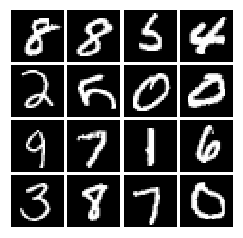

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [5]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(alpha * x, x, name='leaky_relu')

Test your leaky ReLU implementation. You should get errors < 1e-10

In [6]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [7]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform([batch_size,dim], minval=-1, maxval=1, dtype=tf.float32)

Make sure noise is the correct shape and type:

In [8]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms. For initialization, just use the default initializer used by the `tf.layers` functions.

Architecture:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 1 
 
The output of the discriminator should thus have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [9]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        dense_1 = tf.layers.dense(inputs=x,units=256,use_bias=True)
        relu_1=leaky_relu(dense_1, alpha=0.01)
        dense_2 = tf.layers.dense(inputs=relu_1,units=256,use_bias=True)
        relu_2=leaky_relu(dense_2, alpha=0.01)
        dense_3 = tf.layers.dense(inputs=relu_2,units=1,use_bias=True)
        logits=dense_3
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [10]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms. Note that you can use the tf.nn module to access activation functions. Once again, use the default initializers for parameters.

Architecture:
 * Fully connected layer with inupt size tf.shape(z)[1] (the number of noise dimensions) and output size 1024
 * `ReLU`
 * Fully connected layer with output size 1024 
 * `ReLU`
 * Fully connected layer with output size 784
 * `TanH` (To restrict every element of the output to be in the range [-1,1])

In [11]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        dense_1 = tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu,use_bias=True)
        dense_2 = tf.layers.dense(inputs=dense_1,units=1024,activation=tf.nn.relu,use_bias=True)
        dense_3 = tf.layers.dense(inputs=dense_2,units=784,use_bias=True)
        img=tf.tanh(dense_3)
        return img

Test to make sure the number of parameters in the generator is correct:

In [12]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [tf.nn.sigmoid_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [13]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    
    HINT: for the discriminator loss, you'll want to do the averaging separately for
    its two components, and then add them together (instead of averaging once at the very end).
    """
    # TODO: compute D_loss and G_loss
    D_real_loss=tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real),logits=logits_real)
    D_fake_loss=tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake),logits=logits_fake)
    D_loss=tf.reduce_mean(D_real_loss+D_fake_loss)
    
    G_loss=tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake),logits=logits_fake)
    G_loss=tf.reduce_mean(G_loss)
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [14]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 1.20519e-16
Maximum error in g_loss: 7.19722e-17


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [15]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [16]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? After the first epoch, you should see fuzzy outlines, clear shapes as you approach epoch 3, and decent shapes, about half of which will be sharp and clearly recognizable as we pass epoch 5. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [17]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch, minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

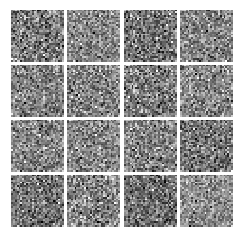


Iter: 0, D: 1.273, G:0.7457
Iter: 50, D: 0.2704, G:1.854
Iter: 100, D: 1.421, G:2.182
Iter: 150, D: 1.557, G:1.001
Iter: 200, D: 1.416, G:1.412


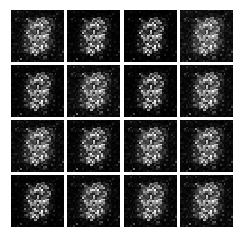


Iter: 250, D: 1.552, G:0.9143
Iter: 300, D: 1.212, G:1.69
Iter: 350, D: 1.074, G:1.029
Iter: 400, D: 1.316, G:0.8948
Iter: 450, D: 1.151, G:1.21


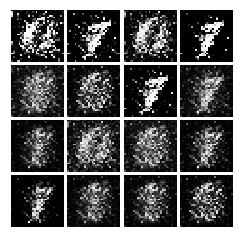


Iter: 500, D: 1.292, G:1.214
Iter: 550, D: 1.205, G:1.203
Iter: 600, D: 0.7444, G:1.504
Iter: 650, D: 1.184, G:1.928
Iter: 700, D: 1.366, G:0.9823


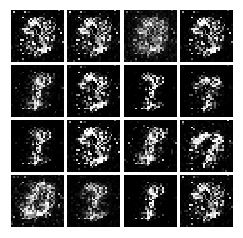


Iter: 750, D: 1.186, G:1.601
Iter: 800, D: 1.437, G:2.025
Iter: 850, D: 1.076, G:1.796
Iter: 900, D: 1.039, G:1.879
Iter: 950, D: 2.073, G:2.729


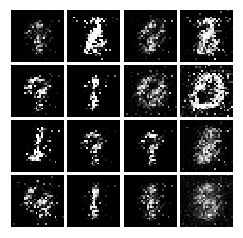


Iter: 1000, D: 1.165, G:1.605
Iter: 1050, D: 1.214, G:1.033
Iter: 1100, D: 1.331, G:1.078
Iter: 1150, D: 1.399, G:1.026
Iter: 1200, D: 1.205, G:1.369


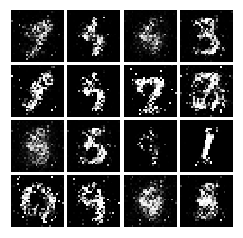


Iter: 1250, D: 2.222, G:0.8502
Iter: 1300, D: 1.358, G:0.7589
Iter: 1350, D: 1.28, G:0.8983
Iter: 1400, D: 1.261, G:0.8204
Iter: 1450, D: 1.298, G:1.05


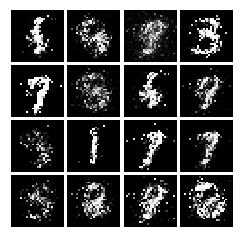


Iter: 1500, D: 1.244, G:0.8909
Iter: 1550, D: 1.368, G:0.9117
Iter: 1600, D: 1.399, G:0.8895
Iter: 1650, D: 1.204, G:0.9944
Iter: 1700, D: 1.269, G:0.8715


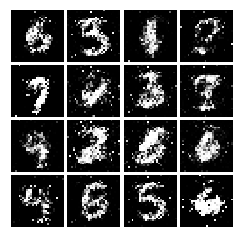


Iter: 1750, D: 1.343, G:0.8176
Iter: 1800, D: 1.318, G:0.744
Iter: 1850, D: 1.318, G:0.9122
Iter: 1900, D: 1.338, G:0.9042
Iter: 1950, D: 1.352, G:0.8575


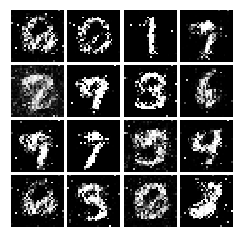


Iter: 2000, D: 1.354, G:0.7918
Iter: 2050, D: 1.337, G:0.7251
Iter: 2100, D: 1.243, G:1.326
Iter: 2150, D: 1.352, G:0.7357
Iter: 2200, D: 1.261, G:1.022


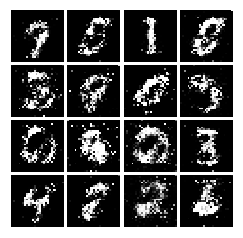


Iter: 2250, D: 1.244, G:0.8418
Iter: 2300, D: 1.427, G:0.8856
Iter: 2350, D: 1.31, G:0.534
Iter: 2400, D: 1.346, G:0.8315
Iter: 2450, D: 1.266, G:0.925


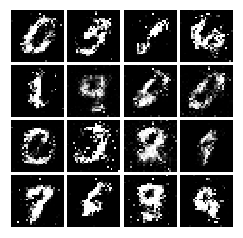


Iter: 2500, D: 1.376, G:0.7518
Iter: 2550, D: 1.333, G:0.8052
Iter: 2600, D: 1.355, G:0.7791
Iter: 2650, D: 1.325, G:0.8073
Iter: 2700, D: 1.316, G:0.8124


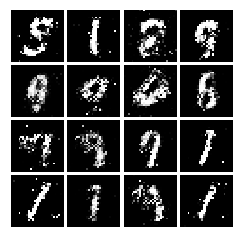


Iter: 2750, D: 1.312, G:0.778
Iter: 2800, D: 1.331, G:0.9567
Iter: 2850, D: 1.24, G:0.7679
Iter: 2900, D: 1.286, G:0.8221
Iter: 2950, D: 1.295, G:0.8264


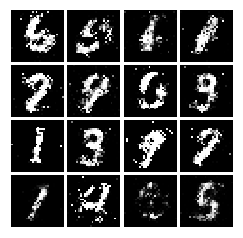


Iter: 3000, D: 1.318, G:0.9539
Iter: 3050, D: 1.385, G:0.8656
Iter: 3100, D: 1.335, G:0.9196
Iter: 3150, D: 1.252, G:0.9199
Iter: 3200, D: 1.724, G:0.6292


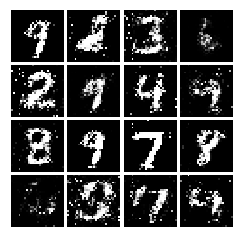


Iter: 3250, D: 1.322, G:0.797
Iter: 3300, D: 1.296, G:0.7881
Iter: 3350, D: 1.314, G:0.7969
Iter: 3400, D: 1.376, G:0.839
Iter: 3450, D: 1.28, G:0.7427


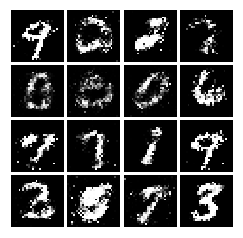


Iter: 3500, D: 1.302, G:1.278
Iter: 3550, D: 1.294, G:0.7724
Iter: 3600, D: 1.345, G:0.7384
Iter: 3650, D: 1.347, G:0.9053
Iter: 3700, D: 1.313, G:0.8718


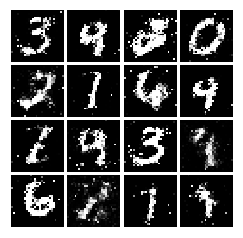


Iter: 3750, D: 1.332, G:0.7738
Iter: 3800, D: 1.368, G:0.8249
Iter: 3850, D: 1.341, G:0.8582
Iter: 3900, D: 1.297, G:0.7946
Iter: 3950, D: 1.321, G:0.7988


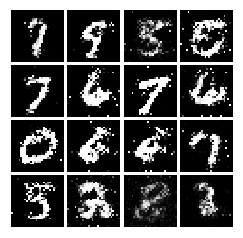


Iter: 4000, D: 1.41, G:0.822
Iter: 4050, D: 1.371, G:0.7745
Iter: 4100, D: 1.312, G:0.7559
Iter: 4150, D: 1.333, G:0.7653
Iter: 4200, D: 1.29, G:0.9007


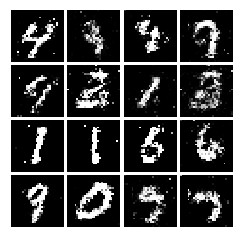


Iter: 4250, D: 1.286, G:0.8837
Final images


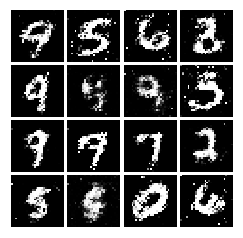

In [18]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN 最小二乘
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [19]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - scores_real: Tensor, shape [batch_size, 1], output of discriminator
        The score for each real image
    - scores_fake: Tensor, shape[batch_size, 1], output of discriminator
        The score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = 0.5*tf.square(score_real-1)+0.5*tf.square(score_fake)
    G_loss = 0.5*tf.square(score_fake-1)
    
    D_loss=tf.reduce_mean(D_loss)
    G_loss=tf.reduce_mean(G_loss)
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [20]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 5.91479e-17
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [21]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

_Run the following cell to train your model!_

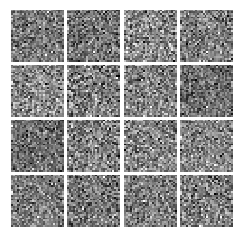


Iter: 0, D: 0.1622, G:0.3573
Iter: 50, D: 0.05985, G:0.7467
Iter: 100, D: 0.3604, G:1.27
Iter: 150, D: 0.1517, G:0.3742
Iter: 200, D: 0.1411, G:1.016


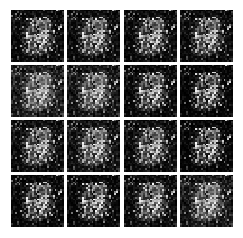


Iter: 250, D: 0.1337, G:0.6184
Iter: 300, D: 0.1021, G:0.3391
Iter: 350, D: 0.1144, G:0.5446
Iter: 400, D: 0.1507, G:0.4474
Iter: 450, D: 0.1158, G:0.2666


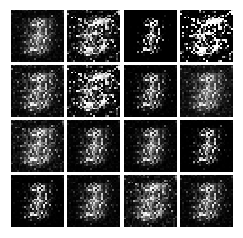


Iter: 500, D: 0.1977, G:0.1672
Iter: 550, D: 0.1859, G:0.495
Iter: 600, D: 0.2442, G:0.2107
Iter: 650, D: 0.4038, G:0.9324
Iter: 700, D: 0.1428, G:0.4208


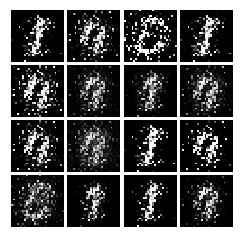


Iter: 750, D: 0.08864, G:0.3133
Iter: 800, D: 0.1558, G:0.3495
Iter: 850, D: 0.1304, G:0.4434
Iter: 900, D: 0.09669, G:0.3779
Iter: 950, D: 0.1025, G:0.3801


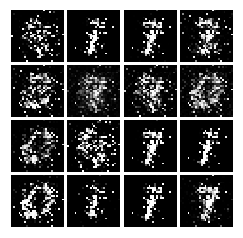


Iter: 1000, D: 0.1119, G:0.3531
Iter: 1050, D: 0.1204, G:0.4649
Iter: 1100, D: 0.3769, G:0.504
Iter: 1150, D: 0.1121, G:0.4229
Iter: 1200, D: 0.09532, G:0.4068


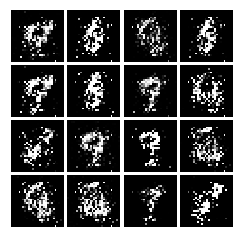


Iter: 1250, D: 0.1161, G:0.4381
Iter: 1300, D: 0.1853, G:0.153
Iter: 1350, D: 0.1556, G:0.3077
Iter: 1400, D: 0.1465, G:0.3086
Iter: 1450, D: 0.1968, G:0.1988


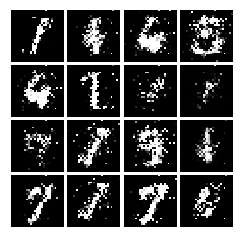


Iter: 1500, D: 0.1365, G:0.2103
Iter: 1550, D: 0.1744, G:0.2361
Iter: 1600, D: 0.1952, G:0.1973
Iter: 1650, D: 0.172, G:0.2871
Iter: 1700, D: 0.1843, G:0.3871


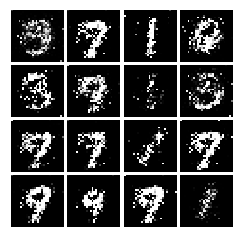


Iter: 1750, D: 0.1671, G:0.2953
Iter: 1800, D: 0.208, G:0.1797
Iter: 1850, D: 0.1806, G:0.2306
Iter: 1900, D: 0.2098, G:0.2058
Iter: 1950, D: 0.1725, G:0.1904


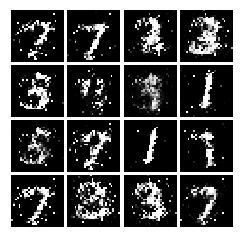


Iter: 2000, D: 0.191, G:0.2107
Iter: 2050, D: 0.2081, G:0.229
Iter: 2100, D: 0.2127, G:0.1674
Iter: 2150, D: 0.2299, G:0.202
Iter: 2200, D: 0.23, G:0.1752


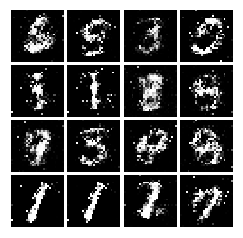


Iter: 2250, D: 0.1858, G:0.2339
Iter: 2300, D: 0.2181, G:0.1963
Iter: 2350, D: 0.2353, G:0.1665
Iter: 2400, D: 0.2168, G:0.2095
Iter: 2450, D: 0.2199, G:0.2019


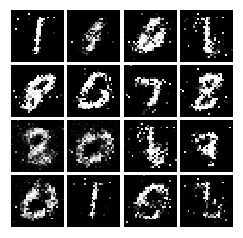


Iter: 2500, D: 0.2104, G:0.2206
Iter: 2550, D: 0.1975, G:0.2091
Iter: 2600, D: 0.2309, G:0.1826
Iter: 2650, D: 0.1949, G:0.2088
Iter: 2700, D: 0.2203, G:0.1868


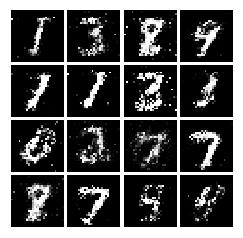


Iter: 2750, D: 0.2108, G:0.2267
Iter: 2800, D: 0.219, G:0.2165
Iter: 2850, D: 0.2071, G:0.1921
Iter: 2900, D: 0.2171, G:0.1805
Iter: 2950, D: 0.1891, G:0.1987


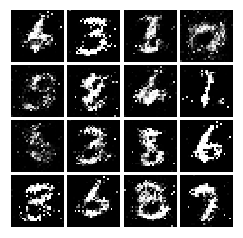


Iter: 3000, D: 0.2175, G:0.1715
Iter: 3050, D: 0.2132, G:0.1847
Iter: 3100, D: 0.2285, G:0.1755
Iter: 3150, D: 0.2134, G:0.1284
Iter: 3200, D: 0.208, G:0.1991


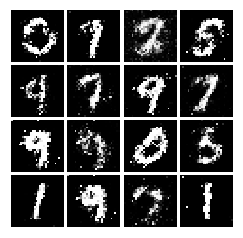


Iter: 3250, D: 0.2145, G:0.1952
Iter: 3300, D: 0.2057, G:0.2561
Iter: 3350, D: 0.2369, G:0.1401
Iter: 3400, D: 0.2041, G:0.1868
Iter: 3450, D: 0.2241, G:0.2003


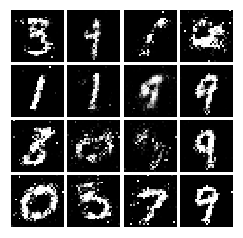


Iter: 3500, D: 0.216, G:0.1766
Iter: 3550, D: 0.2421, G:0.2131
Iter: 3600, D: 0.2131, G:0.1787
Iter: 3650, D: 0.2211, G:0.2157
Iter: 3700, D: 0.2104, G:0.1521


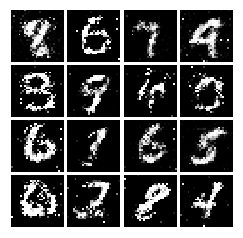


Iter: 3750, D: 0.2225, G:0.1708
Iter: 3800, D: 0.2412, G:0.2074
Iter: 3850, D: 0.2501, G:0.1971
Iter: 3900, D: 0.2486, G:0.1636
Iter: 3950, D: 0.2143, G:0.1612


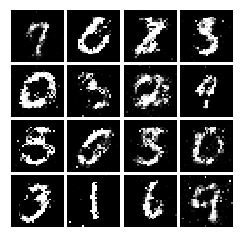


Iter: 4000, D: 0.2402, G:0.1764
Iter: 4050, D: 0.2413, G:0.1693
Iter: 4100, D: 0.2306, G:0.1297
Iter: 4150, D: 0.2262, G:0.1803
Iter: 4200, D: 0.2109, G:0.1668


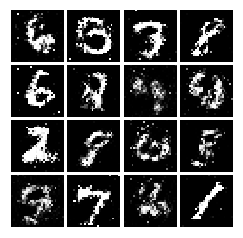


Iter: 4250, D: 0.2171, G:0.1788
Final images


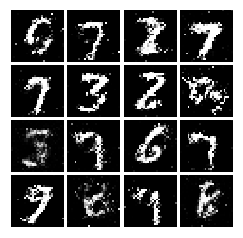

In [22]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. Please use `tf.layers` to define the following architecture:

Architecture:
* Conv2D: 32 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Once again, please use biases for all convolutional and fully connected layers, and use the default parameter initializers. Note that a padding of 0 can be accomplished with the 'VALID' padding option.

In [23]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        x=tf.reshape(x,[-1,28,28,1])
        
        conv_1=tf.layers.conv2d(inputs=x,filters=32,kernel_size=5,strides=(1, 1))
        relu_1=leaky_relu(conv_1, alpha=0.01)
        pool_1=tf.layers.max_pooling2d(inputs=relu_1,pool_size=2,strides=(2, 2))
        
        conv_2=tf.layers.conv2d(inputs=pool_1,filters=64,kernel_size=5,strides=(1, 1))
        relu_2=leaky_relu(conv_2, alpha=0.01)
        pool_2=tf.layers.max_pooling2d(inputs=relu_2,pool_size=2,strides=(2, 2))
        
        flat_1=tf.contrib.layers.flatten(inputs=pool_2)
        dense_1 = tf.layers.dense(inputs=flat_1,units=4*4*64,use_bias=True)
        relu_3=leaky_relu(dense_1, alpha=0.01)
        
        logits = tf.layers.dense(inputs=relu_3,units=1,use_bias=True)
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. Please use `tf.layers` for your implementation. You might find the documentation for [tf.layers.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose) useful. The architecture is as follows.

Architecture:
* Fully connected with output size 1024 
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Resize into Image Tensor of size 7, 7, 128
* Conv2D^T (transpose): 64 filters of 4x4, stride 2
* `ReLU`
* BatchNorm
* Conv2d^T (transpose): 1 filter of 4x4, stride 2
* `TanH`

Once again, use biases for the fully connected and transpose convolutional layers. Please use the default initializers for your parameters. For padding, choose the 'same' option for transpose convolutions. For Batch Normalization, assume we are always in 'training' mode.

In [24]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        dense_1=tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu)
        bn_1=tf.layers.batch_normalization(inputs=dense_1)
        
        dense_2=tf.layers.dense(inputs=bn_1,units=7*7*128,activation=tf.nn.relu)
        bn_2=tf.layers.batch_normalization(inputs=dense_2)
        
        z_img=tf.reshape(bn_2,[-1,7,7,128])
        
        trans_1=tf.layers.conv2d_transpose(inputs=z_img,filters=64,strides=2,kernel_size=4,
                                           padding="same",activation=tf.nn.relu)
        bn_3=tf.layers.batch_normalization(inputs=trans_1)
        img=tf.layers.conv2d_transpose(inputs=bn_3,filters=1,strides=2,kernel_size=4,activation=tf.nn.tanh,padding="same")
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [25]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

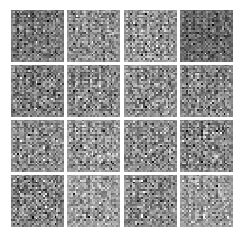


Iter: 0, D: 1.377, G:0.6594
Iter: 50, D: 0.3926, G:3.126
Iter: 100, D: 0.6526, G:2.26
Iter: 150, D: 0.09361, G:3.595
Iter: 200, D: 0.3143, G:2.927


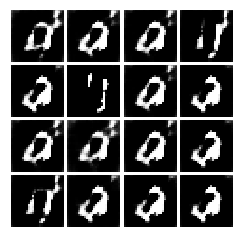


Iter: 250, D: 0.3973, G:2.834
Iter: 300, D: 0.3081, G:2.695
Iter: 350, D: 0.8197, G:6.744
Iter: 400, D: 1.363, G:4.452
Iter: 450, D: 0.8255, G:2.402


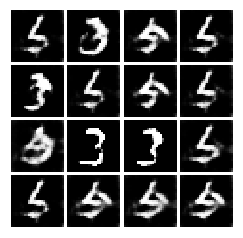


Iter: 500, D: 0.3543, G:2.623
Iter: 550, D: 0.5779, G:2.265
Iter: 600, D: 0.6527, G:2.184
Iter: 650, D: 0.6319, G:2.641
Iter: 700, D: 0.4104, G:2.793


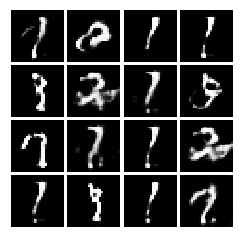


Iter: 750, D: 0.5236, G:1.638
Iter: 800, D: 0.5581, G:2.109
Iter: 850, D: 0.7178, G:1.565
Iter: 900, D: 0.6861, G:1.536
Iter: 950, D: 1.163, G:0.6624


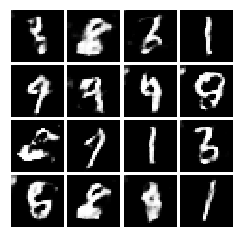


Iter: 1000, D: 1.177, G:1.572
Iter: 1050, D: 0.6209, G:2.152
Iter: 1100, D: 0.6311, G:1.795
Iter: 1150, D: 0.6078, G:1.534
Iter: 1200, D: 0.7263, G:2.024


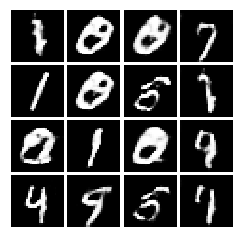


Iter: 1250, D: 0.6209, G:2.304
Iter: 1300, D: 0.7032, G:1.804
Iter: 1350, D: 0.7475, G:1.4
Iter: 1400, D: 0.6701, G:2.365
Iter: 1450, D: 0.616, G:1.554


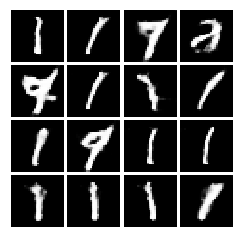


Iter: 1500, D: 0.6025, G:2.266
Iter: 1550, D: 0.5274, G:1.98
Iter: 1600, D: 0.8104, G:2.52
Iter: 1650, D: 0.6057, G:2.09
Iter: 1700, D: 0.5563, G:2.154


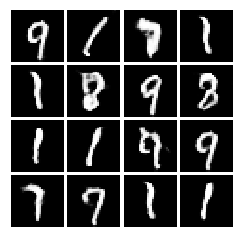


Iter: 1750, D: 1.012, G:1.338
Iter: 1800, D: 0.5426, G:2.266
Iter: 1850, D: 1.255, G:2.138
Iter: 1900, D: 0.661, G:1.895
Iter: 1950, D: 0.7568, G:2.285


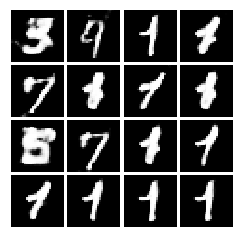


Iter: 2000, D: 0.5865, G:2.61
Iter: 2050, D: 0.6145, G:2.202
Iter: 2100, D: 0.4815, G:2.067
Final images


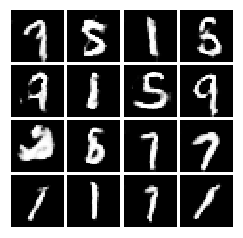

In [26]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

## INLINE QUESTION 1

We will look at an example to see why alternating minimization of the same objective (like in a GAN) can be tricky business.

Consider $f(x,y)=xy$. What does $\min_x\max_y f(x,y)$ evaluate to? (Hint: minmax tries to minimize the maximum value achievable.)

Now try to evaluate this function numerically for 6 steps, starting at the point $(1,1)$, 
by using alternating gradient (first updating y, then updating x) with step size $1$. 
You'll find that writing out the update step in terms of $x_t,y_t,x_{t+1},y_{t+1}$ will be useful.

Record the six pairs of explicit values for $(x_t,y_t)$ in the table below.

### Your answer:
 
 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$ 
 ----- | ----- | ----- | ----- | ----- | ----- | ----- 
   1   |       |       |       |       |       |       
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$ 
   1   |       |       |       |       |       |       
   

## INLINE QUESTION 2
Using this method, will we ever reach the optimal value? Why or why not?

### Your answer:

## INLINE QUESTION 3
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient

### Your answer:

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [27]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        x=tf.reshape(x,[-1,28,28,1])
        conv_1=tf.layers.conv2d(inputs=x,filters=64,kernel_size=4,strides=2)
        relu_1=leaky_relu(conv_1)
        
        conv_2=tf.layers.conv2d(inputs=relu_1,filters=128,kernel_size=4,strides=2)
        relu_2=leaky_relu(conv_2)
        
        bn_1=tf.layers.batch_normalization(inputs=relu_2)
        
        flat_1=tf.contrib.layers.flatten(inputs=bn_1)
        
        dense_1=tf.layers.dense(inputs=flat_1,units=1024)
        relu_3=leaky_relu(dense_1)
        
        logits=tf.layers.dense(inputs=relu_3,units=1)
        return logits
test_discriminator(3411649)

Correct number of parameters in discriminator.


In [28]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [29]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = -( tf.reduce_mean(logits_real) - tf.reduce_mean(logits_fake) )
    G_loss = - tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform(shape=[batch_size,1],minval=0,maxval=1)
    G_sample_falt=tf.reshape(G_sample, [batch_size,-1])
    x_hat = eps*x+(1-eps)*G_sample_falt

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat),x_hat)

    grad_norm = tf.norm(grad_D_x_hat)
    grad_pen = lam*tf.square(grad_norm-1)

    D_loss+=grad_pen
    
    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

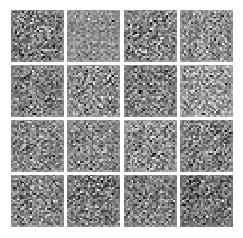


Iter: 0, D: -0.064, G:-0.04991
Iter: 50, D: -0.2901, G:-0.4811
Iter: 100, D: -1.083, G:1.076
Iter: 150, D: -0.4358, G:-1.833
Iter: 200, D: -0.6081, G:0.9522


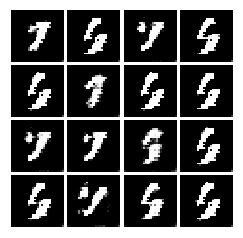


Iter: 250, D: -0.1424, G:1.109
Iter: 300, D: -0.4283, G:0.07622
Iter: 350, D: -0.4947, G:0.1932
Iter: 400, D: 0.04016, G:0.9167
Iter: 450, D: 0.01822, G:0.6403


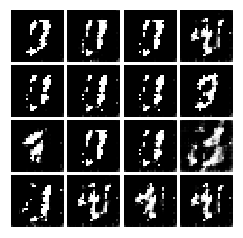


Iter: 500, D: 0.2835, G:0.01524
Iter: 550, D: -0.1117, G:-0.04636
Iter: 600, D: -0.2172, G:0.6157
Iter: 650, D: -0.1104, G:-0.4165
Iter: 700, D: -0.07164, G:0.453


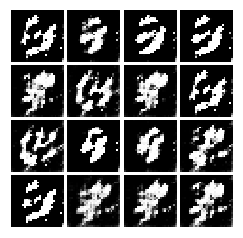


Iter: 750, D: -0.08092, G:-0.4268
Iter: 800, D: -0.5373, G:1.057
Iter: 850, D: -0.07285, G:1.559
Iter: 900, D: -0.1448, G:0.1473
Iter: 950, D: -0.1303, G:0.1862


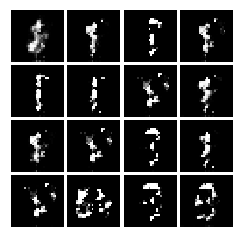


Iter: 1000, D: 0.4149, G:0.2058
Iter: 1050, D: -0.2051, G:-0.6248
Iter: 1100, D: -0.2848, G:0.7973
Iter: 1150, D: 0.02029, G:-0.2567
Iter: 1200, D: 0.2044, G:-0.3263


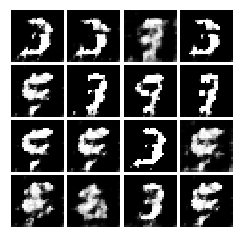


Iter: 1250, D: -0.01596, G:-0.4508
Iter: 1300, D: -0.1394, G:0.4907
Iter: 1350, D: -0.02918, G:-0.01541
Iter: 1400, D: -0.09898, G:0.6641
Iter: 1450, D: -0.1228, G:-0.5601


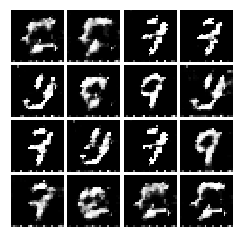


Iter: 1500, D: -0.003513, G:-0.9655
Iter: 1550, D: -0.278, G:-0.5872
Iter: 1600, D: 0.0488, G:-0.685
Iter: 1650, D: -0.2152, G:-0.1441
Iter: 1700, D: -0.002122, G:-0.7445


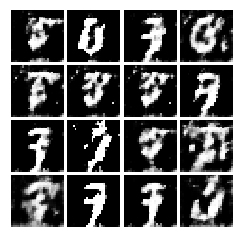


Iter: 1750, D: 0.02164, G:-0.1153
Iter: 1800, D: -0.0465, G:0.7874
Iter: 1850, D: 0.002994, G:0.4273
Iter: 1900, D: -0.2524, G:0.5956
Iter: 1950, D: -0.1188, G:0.3807


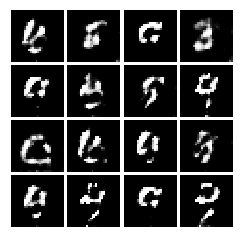


Iter: 2000, D: 0.02462, G:0.0439
Iter: 2050, D: 0.03519, G:0.2543
Iter: 2100, D: 0.02714, G:0.5378
Final images


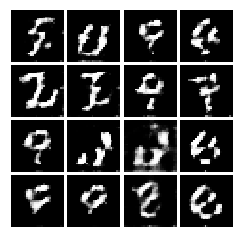

In [30]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)